In [1]:
!pip install xarray netCDF4 pandas seaborn matplotlib

Ignoring numpy: markers 'python_version < "3.11"' don't match your environment


In [2]:
# Import required libraries
import requests
import os
import json

# Define the Invenio repository API endpoint and DOI
api_base_url = "https://zenodo.org/api/records"
doi = "10.5281/zenodo.6961511"  # ERA-NUTS dataset DOI
record_id = "6961511"  # Extracted from DOI
file_name = "era-nuts-t2m-nuts2-hourly.nc"  # File to download

# Define local directory to save the file
output_dir = "./era5_data"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, file_name)

# Set headers to include a user-agent to avoid rate-limiting
headers = {
    "User-Agent": "Python-Requests/ERA-NUTS-Downloader"
}

# Function to get record metadata by DOI or record ID
def get_record(api_url, doi, record_id):
    try:
        # First, try querying by DOI
        print(f"Querying Zenodo API for DOI: {doi}")
        response = requests.get(f"{api_url}?q=doi:\"{doi}\"", headers=headers)
        if response.status_code == 200:
            data = response.json()
            hits = data.get("hits", {}).get("hits", [])
            if hits:
                print("Record found via DOI query.")
                return hits[0]
            else:
                print("No records found via DOI query. Trying record ID...")
        
        # Fallback: Query directly by record ID
        response = requests.get(f"{api_url}/{record_id}", headers=headers)
        if response.status_code == 200:
            print("Record found via record ID.")
            return response.json()
        else:
            print(f"Failed to query API. HTTP status: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error querying API: {str(e)}")
        return None

# Function to download a specific file from the record
def download_file_from_record(record, file_name, output_path):
    try:
        # Extract files from the record metadata
        files = record.get("files", [])
        file_url = None
        for file in files:
            if file.get("key") == file_name:
                file_url = file.get("links", {}).get("self")
                break
        
        if not file_url:
            print(f"File {file_name} not found in record. Available files: {[f['key'] for f in files]}")
            return False
        
        # Download the file
        print(f"Downloading {file_name} from {file_url}...")
        response = requests.get(file_url, stream=True, headers=headers)
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            downloaded_size = 0
            chunk_size = 1024 * 1024  # 1 MB chunks
            
            with open(output_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=chunk_size):
                    if chunk:
                        f.write(chunk)
                        downloaded_size += len(chunk)
                        if total_size > 0:
                            progress = (downloaded_size / total_size) * 100
                            print(f"Downloaded {downloaded_size / 1024 / 1024:.2f} MB of {total_size / 1024 / 1024:.2f} MB ({progress:.2f}%)", end='\r')
            print(f"\nFile saved to {output_path}")
            return True
        else:
            print(f"Failed to download file. HTTP status: {response.status_code}")
            return False
    except Exception as e:
        print(f"Error downloading file: {str(e)}")
        return False

# Main execution
record = get_record(api_base_url, doi, record_id)
if record:
    success = download_file_from_record(record, file_name, output_path)
    if success and os.path.exists(output_path):
        print(f"File {file_name} is ready for use at {output_path}")
    else:
        print(f"File {file_name} was not downloaded successfully.")
else:
    print("Could not retrieve record metadata.")

Querying Zenodo API for DOI: 10.5281/zenodo.6961511
Record found via DOI query.
Downloaded 219.83 MB of 219.83 MB (100.00%)
File saved to ./era5_data/era-nuts-t2m-nuts2-hourly.nc
File era-nuts-t2m-nuts2-hourly.nc is ready for use at ./era5_data/era-nuts-t2m-nuts2-hourly.nc


All required libraries are installed.
xarray version: 2025.7.1
Dataset loaded successfully:
<xarray.Dataset> Size: 913MB
Dimensions:  (time: 368184, region: 309)
Coordinates:
  * time     (time) datetime64[ns] 3MB 1980-01-01 ... 2021-12-31T23:00:00
  * region   (region) <U4 5kB 'AL01' 'AL02' 'AL03' ... 'UKM8' 'UKM9' 'UKN0'
Data variables:
    t2m      (time, region) float64 910MB ...
Temperature units: Not specified
Selected data for NUTS2 region CZ01 in year 2020


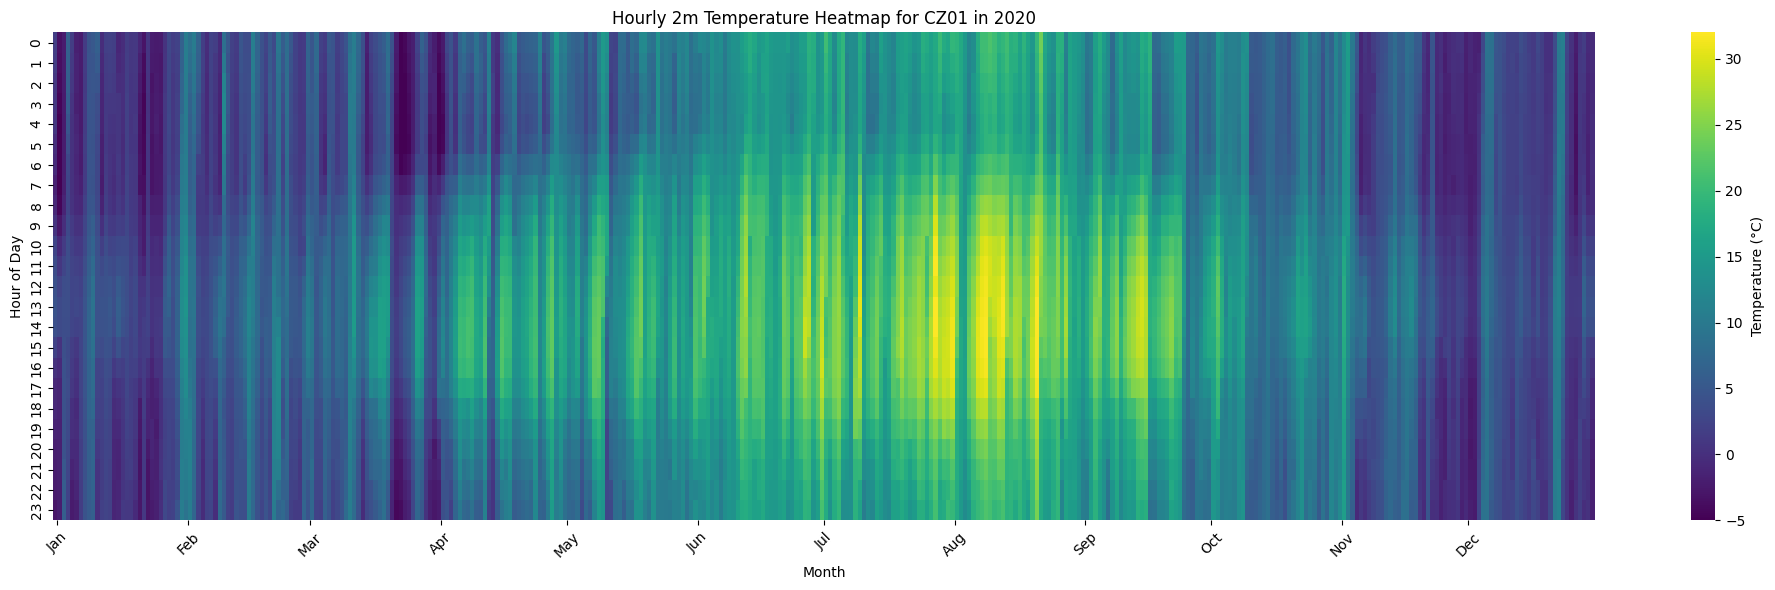

In [5]:
# Import required libraries
import os
from datetime import datetime
try:
    import xarray as xr
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    print("All required libraries are installed.")
    print(f"xarray version: {xr.__version__}")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install required libraries: pip install xarray netCDF4 pandas seaborn matplotlib")
    raise

# Define the path to the downloaded file
file_path = "./era5_data/era-nuts-t2m-nuts2-hourly.nc"

# Check if the file exists
if not os.path.exists(file_path):
    print(f"File not found at {file_path}. Please ensure the file was downloaded correctly.")
    raise FileNotFoundError(f"File {file_path} does not exist.")

# Open the NetCDF file with xarray
try:
    ds = xr.open_dataset(file_path)
    print("Dataset loaded successfully:")
    print(ds)
    # Check temperature units
    print(f"Temperature units: {ds['t2m'].attrs.get('units', 'Not specified')}")
except Exception as e:
    print(f"Error opening file: {str(e)}")
    print("Ensure 'netCDF4' is installed: pip install netCDF4")
    print("On Ubuntu, you may need: sudo apt-get install libnetcdf-dev")
    raise

# Select a specific NUTS2 region and year
nuts_region = 'CZ01'  # Prague, Czech Republic
selected_year = 2020  # Change to 2018 if 2020 is unavailable; dataset likely covers 1979–2018

try:
    # Filter by region and year
    data = ds['t2m'].sel(region=nuts_region, time=str(selected_year))
    print(f"Selected data for NUTS2 region {nuts_region} in year {selected_year}")
except Exception as e:
    print(f"Error selecting region {nuts_region} or year {selected_year}: {str(e)}")
    print("Available NUTS2 regions:", ds['region'].values)
    print("Available time range:", ds['time'].min().values, "to", ds['time'].max().values)
    raise

# Convert to pandas DataFrame
df = data.to_dataframe().reset_index()

# Extract day of year and hour for pivot table
df['day_of_year'] = pd.to_datetime(df['time']).dt.dayofyear
df['hour'] = pd.to_datetime(df['time']).dt.hour

# Create a pivot table for the heatmap (hours vs. days)
pivot_table = df.pivot_table(index='hour', columns='day_of_year', values='t2m', aggfunc='mean')

# Plot the heatmap with fixed temperature scale
plt.figure(figsize=(20, 6))  # Match previous graph size
sns.heatmap(pivot_table, cmap='viridis', cbar_kws={'label': 'Temperature (°C)'}, vmin=-5, vmax=32)
plt.title(f"Hourly 2m Temperature Heatmap for {nuts_region} in {selected_year}")
plt.xlabel("Month")
plt.ylabel("Hour of Day")

# Customize x-axis with month start dates
start_date = datetime(selected_year, 1, 1)
month_starts = [datetime(selected_year, m, 1) for m in range(1, 13)]  # Jan 1, Feb 1, ..., Dec 1
days_since_start = [(d - start_date).days + 1 for d in month_starts]  # Convert to day-of-year indices
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(days_since_start, month_labels, rotation=45)

plt.tight_layout()

# Show the plot
plt.show()

# Close the dataset to free memory
ds.close()